<a href="https://colab.research.google.com/github/martush/martush_notebooks/blob/develop/Char_Level_Language_Model_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2026-02-26 12:01:22--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.004s  

2026-02-26 12:01:22 (58.4 MB/s) - ‘names.txt’ saved [228145/228145]



In [5]:
#words = open('gdrive/My Drive/names.txt', 'r').read().splitlines()
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [7]:
#build vocabulary of all chars and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
#build dataset
block_size = 3 #context length - how many input chars to predict next
X, Y = [], []

for w in words[:5]:
  print(w)
  context = [0] * block_size
  print(f'Context: {context}')
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '---->', itos[ix])
    context = context[1:] + [ix] #crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
Context: [0, 0, 0]
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
Context: [0, 0, 0]
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
Context: [0, 0, 0]
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
Context: [0, 0, 0]
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
Context: [0, 0, 0]
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [8]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [9]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

## Construct embeddings

Now to create the lookup table. In the reference paper they have 17,000 words crammed into 30 dimensions. We only have 27 characters and we can start  with only 2 dimensions.

In [10]:
C = torch.randn((27,2))

In [11]:
# Lets check a single embedding
C[5]

tensor([-0.0277,  0.5534])

In [12]:
C[torch.tensor([5,6,7,7,7])]

tensor([[-0.0277,  0.5534],
        [-0.2966, -0.6386],
        [ 1.8751,  0.5686],
        [ 1.8751,  0.5686],
        [ 1.8751,  0.5686]])

In [13]:
# We can also index with multiple dimension
C[X]

tensor([[[ 0.4555,  0.1159],
         [ 0.4555,  0.1159],
         [ 0.4555,  0.1159]],

        [[ 0.4555,  0.1159],
         [ 0.4555,  0.1159],
         [-0.0277,  0.5534]],

        [[ 0.4555,  0.1159],
         [-0.0277,  0.5534],
         [ 0.2705, -0.6979]],

        [[-0.0277,  0.5534],
         [ 0.2705, -0.6979],
         [ 0.2705, -0.6979]],

        [[ 0.2705, -0.6979],
         [ 0.2705, -0.6979],
         [ 1.7711, -0.8099]],

        [[ 0.4555,  0.1159],
         [ 0.4555,  0.1159],
         [ 0.4555,  0.1159]],

        [[ 0.4555,  0.1159],
         [ 0.4555,  0.1159],
         [ 0.9398, -1.2199]],

        [[ 0.4555,  0.1159],
         [ 0.9398, -1.2199],
         [ 0.1604,  0.5699]],

        [[ 0.9398, -1.2199],
         [ 0.1604,  0.5699],
         [-0.4921,  0.0073]],

        [[ 0.1604,  0.5699],
         [-0.4921,  0.0073],
         [ 0.2876, -1.5037]],

        [[-0.4921,  0.0073],
         [ 0.2876, -1.5037],
         [-0.4921,  0.0073]],

        [[ 0.2876, -1

In [14]:
C[X].shape

torch.Size([32, 3, 2])

In [15]:
X[13,2]

tensor(1)

In [16]:
C[X][13,2]

tensor([ 1.7711, -0.8099])

In [17]:
C[1]

tensor([ 1.7711, -0.8099])

In [18]:
encoded = F.one_hot(torch.tensor(5), num_classes=27)
encoded

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [19]:
# one-hot are int64 and C is float - pytorch doesn't know how to multiply them
encoded @ C

RuntimeError: expected m1 and m2 to have the same dtype, but got: long int != float

In [20]:
# identical output
encoded.float() @ C

tensor([-0.0277,  0.5534])

2 approaches with identical results. Will simply index (C[5]) since much faster

In [21]:
# Pytorch indexing is quite flexible and powerful
# We have a X with size [32, 3] which we want to embed
# We can index 3 things at the same time
C[[5,6,7]]

tensor([[-0.0277,  0.5534],
        [-0.2966, -0.6386],
        [ 1.8751,  0.5686]])

In [22]:
# This is our embedding
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

## Construct the hidden layer

In [23]:
# torch.Size([32, 3, 2])
# Inputs: 3 x 2 - 3 two-dimensional embeddings
# Outputs we pick - pick 100 neurons
W1 = torch.randn((6, 100))
# biases - initialized randomly, need 100 of them
b1 = torch.randn(100)

In [25]:
# Normally we'd take the input and multiply it by the weights
emb @ W1 + b1
# Problem is the embeddings are stacked up in the dimensions in the input tensor - 32 x 3 x 1 can't multiply by 6 x 100
# We need to concatenate the inputs

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

There are multiple ways to concatenate the dimensions.

In [26]:
# First way - use torch.concat
emb[:, 0, :].shape
# These are the embeddings of the first word

torch.Size([32, 2])

In [27]:
# These are the dimensions we want to concatenate
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [28]:
# The above way is not scalable since directly indexing into the 3 dimensions - unbind (removes a tensor dimension and returns slices of it)
len(torch.unbind(emb, 1))
# exactly equal to the list above

3

In [29]:
# This is inefficient because it creates all kinds of new memory - 2 tensors cannot be manipulated like that without new memory being created
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [30]:
# Better way
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [31]:
a.shape

torch.Size([18])

In [32]:
a.view(9, 2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

As long as the total number of elements multiply to be the number of the original vector, you can pick any dimensions.
This is extremely efficient - each tensor has underlying storage which is just the numbers in a 1-dimensional vector.
No memory is changed when calling .view - the underlying storage is the same, only the view of this tensor is changed -  storage offset, strides and shape

In [33]:
a.storage()

/tmp/ipython-input-686/214256462.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [34]:
emb.shape

torch.Size([32, 3, 2])

In [35]:
emb.view(32, 6)

tensor([[ 0.4555,  0.1159,  0.4555,  0.1159,  0.4555,  0.1159],
        [ 0.4555,  0.1159,  0.4555,  0.1159, -0.0277,  0.5534],
        [ 0.4555,  0.1159, -0.0277,  0.5534,  0.2705, -0.6979],
        [-0.0277,  0.5534,  0.2705, -0.6979,  0.2705, -0.6979],
        [ 0.2705, -0.6979,  0.2705, -0.6979,  1.7711, -0.8099],
        [ 0.4555,  0.1159,  0.4555,  0.1159,  0.4555,  0.1159],
        [ 0.4555,  0.1159,  0.4555,  0.1159,  0.9398, -1.2199],
        [ 0.4555,  0.1159,  0.9398, -1.2199,  0.1604,  0.5699],
        [ 0.9398, -1.2199,  0.1604,  0.5699, -0.4921,  0.0073],
        [ 0.1604,  0.5699, -0.4921,  0.0073,  0.2876, -1.5037],
        [-0.4921,  0.0073,  0.2876, -1.5037, -0.4921,  0.0073],
        [ 0.2876, -1.5037, -0.4921,  0.0073,  1.7711, -0.8099],
        [ 0.4555,  0.1159,  0.4555,  0.1159,  0.4555,  0.1159],
        [ 0.4555,  0.1159,  0.4555,  0.1159,  1.7711, -0.8099],
        [ 0.4555,  0.1159,  1.7711, -0.8099,  0.2876, -1.5037],
        [ 1.7711, -0.8099,  0.2876, -1.5

In [36]:
# Verify result same as before
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [38]:
# Now multiply to create the hiden layer
h = emb.view(32, 6) @ W1 + b1

#Improve - remove harcoding of the 32
h = emb.view(emb.shape[0], 6) @ W1 + b1
#can also do -1 - since the number of elements needs to be the same and we have the other as 6, pytorch will derive this to be 32
h = emb.view(-1, 6) @ W1 + b1
# Also add tanh the whole thing
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [39]:
# Need to be careful with the broadcasting rules for adding b1
# We have 32, 100 added to 100
# 32, 100
#     100
#pytorch will align them on the right, create  a fake dimension (1x100 row vector) and then copy vertically for every one of the 32 rows and do an element-wise addition
# in this case the correct thing will be happening

In [40]:
h.shape
# 32 x 100: the 100 activations for our 32 examples

torch.Size([32, 100])

## Output Layer

In [41]:
# Input is 100 (outputs from hidden layer), outputs are 27  (the 27 characters)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [42]:
logits = h @ W2 + b2

In [43]:
logits.shape

torch.Size([32, 27])

In [44]:
logits

tensor([[-1.1922e+01,  5.9192e+00, -5.6534e+00, -5.9271e+00, -2.4147e+00,
          4.8278e+00, -1.2175e-01, -3.3778e-01,  6.6944e+00, -3.0145e+00,
          3.3080e+00,  7.9317e+00, -8.0728e+00,  1.6796e+01,  1.0634e+01,
          2.1831e-01, -7.6707e+00,  1.2703e+01, -1.4151e+00, -1.7538e+01,
         -4.2213e-01, -2.8458e-01,  2.2046e+00, -1.4590e+00, -8.3448e+00,
          1.6950e+00, -1.5516e+00],
        [-1.1701e+01,  8.0438e+00, -3.7716e+00, -6.2239e+00, -6.5065e+00,
          5.2619e+00, -9.9251e-01, -3.1575e+00,  9.5580e+00, -2.1191e+00,
          4.6941e-01,  9.5979e+00, -9.3213e+00,  2.0869e+01,  1.0158e+01,
         -4.9476e+00, -7.3251e+00,  9.9857e+00, -1.1791e+00, -1.3752e+01,
          1.8797e+00,  3.1247e+00, -8.1864e-01, -1.0711e+00, -3.0590e+00,
         -4.3221e+00, -5.2999e+00],
        [-1.0823e+01,  1.1739e+01, -3.2731e+00, -1.6255e+00,  2.3485e+00,
         -1.6236e+00,  9.7464e+00,  5.9996e+00,  1.6120e-02, -1.4640e+01,
          1.9359e+00, -6.5945e+00,  6.78

In [45]:
counts = logits.exp()

In [46]:
prob = counts / counts.sum(1, keepdims=True)

In [47]:
prob.shape

torch.Size([32, 27])

In [48]:
# Every row sums up to 1
prob[0].sum()

tensor(1.0000)

## Loss function

In [49]:
# Index into the rows of prob and from each row pluck out the probability assigned to the correct character
# iterator
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [50]:
# Indices of correct characters
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [51]:
prob[torch.arange(32), Y]

tensor([6.2238e-06, 9.9993e-01, 3.2319e-02, 6.5073e-07, 6.3481e-06, 6.1966e-08,
        4.1873e-07, 4.1928e-02, 4.6175e-01, 1.2581e-14, 7.6290e-10, 3.6181e-08,
        1.8535e-05, 2.5769e-03, 6.1589e-08, 3.1626e-05, 2.4444e-09, 1.5572e-13,
        2.9433e-03, 1.0300e-09, 2.3938e-08, 9.2299e-12, 2.5631e-07, 3.1231e-04,
        8.3758e-11, 1.2042e-15, 7.2737e-06, 9.5698e-10, 2.3373e-13, 1.9992e-09,
        1.9438e-07, 1.0301e-06])

In [52]:
# This is what we need to minimize to get the correct character
loss = - prob[torch.arange(32), Y].log().mean()
loss

tensor(15.6679)

## Full flow

In [53]:
#dataset
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [54]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [55]:
# number of params
sum(p.nelement() for p in parameters)

3481

In [56]:
# Layer 1: embedding
emb = C[X] #(32, 3, 2) 32 examples with 3 chars each and 2 dimensions to them
# Layer 2: hidden layer
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # outputs (32, 100)
# Layer 3: output
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

In [57]:
# Calculating the loss can be done directly from pytorch
F.cross_entropy(logits, Y)

tensor(17.7697)

In [58]:
# Layer 1: embedding
emb = C[X] #(32, 3, 2) 32 examples with 3 chars each and 2 dimensions to them
# Layer 2: hidden layer
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # outputs (32, 100)
# Layer 3: output
logits = h @ W2 + b2
#counts = logits.exp()
#prob = counts / counts.sum(1, keepdims=True)
#loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

Many reasons to prefer F.cross_entropy over own implementation
1. F.cross_entropy won't create all the intermediate tensors. Pytorch uses fused kernels to more efficienctly calculate
The backwards pass would be much more efficient
2. F.cross_entropy is more numerically well-behaved - example below

In [59]:
logits = torch.tensor([-2, -3, 0, 5])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])

In [60]:
# Supposed we have more extreme numbers
logits = torch.tensor([-100, -3, 0, 5])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 3.3311e-04, 6.6906e-03, 9.9298e-01])

In [61]:
# Supposed we have more extreme positive
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

In [62]:
counts

tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])

If you pass a very positive number to .exp() we run out of range in our floating point number that represents the count(e to the power of 100).

You can offset logits by any arbitrary number you want and get the same result.
F.cross_entropy calculates the max value in the logits and subtracts it

In [63]:
for p in parameters:
    p.requires_grad = True

In [64]:
for _ in range(100):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

0.3367388844490051


We're achieving extremely low loss - overfitting. We are fitting 32 examples using almost 4k parameters - very easy to make the NN fit them.
We can't achieve 0 - ... is supposed to predict 5 different first letters

In [65]:
logits.max(1)

torch.return_types.max(
values=tensor([11.3379, 13.0894, 18.9434, 17.5786, 12.7205, 11.3379, 13.0234, 11.5993,
        13.5442, 15.5540, 12.5548, 17.6663, 11.3379, 12.6919, 13.9530, 17.0410,
        11.3379, 13.8052, 11.4075, 13.1371, 15.8441, 12.1391,  7.9167,  7.8798,
        13.8772, 11.3379, 13.0983, 13.6820, 11.2885, 14.2338, 15.6165, 12.0455],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 13, 13,  1,  0,  1, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  1, 19,
         1,  2,  5, 12, 12,  1,  0,  1, 15, 16,  8,  9,  1,  0]))

## Run on full dataset

In [66]:
#build dataset
block_size = 3 #context length - how many input chars to predict next
X, Y = [], []

for w in words:
  #print(w)
  context = [0] * block_size
  #print(f'Context: {context}')
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '---->', itos[ix])
    context = context[1:] + [ix] #crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [67]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [68]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [69]:
# number of params
sum(p.nelement() for p in parameters)

3481

In [70]:
for p in parameters:
    p.requires_grad = True

In [71]:
for _ in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

19.505226135253906
17.08449363708496
15.776531219482422
14.833340644836426
14.002603530883789
13.253260612487793
12.57991886138916
11.983101844787598
11.47049331665039
11.051856994628906
11.051856994628906


## Minibatches

In practice forward and backwards passes on batches of the data, not the full dataset

In [ ]:
# Numbers between 0 and 5 and make 32 of them - note size is a touple
torch.randint(0, 5, (32,))

In [ ]:
torch.randint(0, X.shape[0], (32,))

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
    p.requires_grad = True

In [89]:
# rerun multiple times
for _ in range(100):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    #print(ix)

    # forward pass
    # now only getting 32 rows of x
    emb = C[X[ix]] # embeddings will be 32,3,2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    # also index the minibatch into Y
    loss = F.cross_entropy(logits, Y[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

2.426982879638672


Much faster to optimize. However, quality of gradient is lower and direction is not as reliable as when using the full data - but good enough.

Much better to have approximate gradient and evaluate many steps than it is to have exact gradient and take fewer steps.

In [90]:
# Evaluate loss on all data, not just the minibatch
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.6775944232940674


## Learning Rate

One issue is that we don't know if we're stepping too slow or too fast. How to determine the learning rate>

In [108]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters)

3481

In [109]:
for p in parameters:
    p.requires_grad = True

In [98]:
for _ in range(100):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    #print(ix)

    # forward pass
    # now only getting 32 rows of x
    emb = C[X[ix]] # embeddings will be 32,3,2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    # also index the minibatch into Y
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    #update
    for p in parameters:
        # try initially with -0.0001
        p.data += -0.001 * p.grad

#print(loss.item())

19.019437789916992
16.594404220581055
19.99174690246582
18.229080200195312
19.725650787353516
20.496427536010742
23.06786346435547
20.07428741455078
21.911394119262695
21.32504653930664
21.348388671875
17.452110290527344
18.344249725341797
19.254547119140625
18.694364547729492
18.827070236206055
21.672927856445312
18.8033504486084
20.816221237182617
21.771732330322266
18.199440002441406
17.6516170501709
16.685096740722656
17.673799514770508
17.154644012451172
19.200288772583008
20.719863891601562
17.416378021240234
19.53897476196289
15.953472137451172
18.946779251098633
21.35677719116211
18.518342971801758
18.172330856323242
18.138874053955078
17.180543899536133
18.05474090576172
18.272186279296875
18.154529571533203
18.859315872192383
18.28801918029785
18.788070678710938
17.432992935180664
16.822572708129883
18.613080978393555
20.626789093017578
17.661113739013672
16.33774757385254
15.973653793334961
19.05153465270996
16.504384994506836
19.694900512695312
18.529340744018555
18.0809135

With -0.0001 loss barely decreases so it's too low. Try -0.001 - decreases but low range.
Try to find the learning rate with which the loss explodes - e.g. -1 - it still kidna works, fast learning rate. Try with -10 - it doesn't optimize at all (loss goes up and down).

-1 is somewhat reasonable but ideally between -1 and -0.001

Use linspace

In [ ]:
torch.linspace(0.001, 1, 1000)

In [36]:
# Change to exponent form
# equivalents to 0.001 and 1
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [110]:
lri_raw = []
lri = []
lossi = []

for i in range(1000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    #update
    lr = lrs[i]
    for p in parameters:
        # try initially with -0.0001
        p.data += -lr * p.grad

    # track
    lri_raw.append(lr)
    lri.append(lre[i])
    lossi.append(loss.item())

print(loss.item())

6.740164756774902


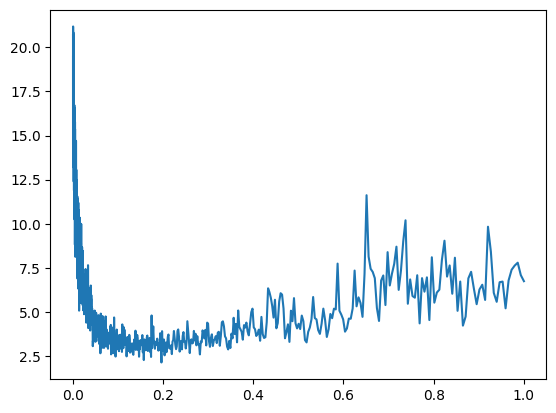

In [111]:
plt.plot(lri_raw, lossi)

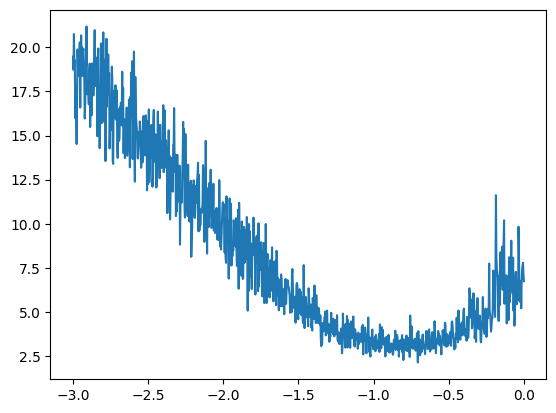

In [112]:
# Change to plotting the exponent of the learning rate
plt.plot(lri, lossi)

In [ ]:
# Looks like best is around 10 to the -1 which is 0.1 (which is the original rate)
# Now run with this learning rate (for a long time)

In [113]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters)

3481

In [114]:
for p in parameters:
    p.requires_grad = True

In [126]:
for i in range(10000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    #update
    #lr = 10**-1 #(equal to 0.1)
    lr = 0.001
    for p in parameters:
        p.data += -lr * p.grad

#print(loss.item())

In [127]:
# Evaluate loss on all data, not just the minibatch
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.2943532466888428


At the late stages of training, decay the learning rate (10x lower it)

## Dataset Split

We are achieving a lower loss than the bigram model, however, we are overfitting. As the NN grows (more parameters) it becomes more and more capable of overfitting the dataset. The model is memorizing your dataset verbatim. If you try to sample from it, you'd only get examples which are in the dataset. If you try to evaluate the loss on some hidden words, you'll see it's not very good.
So standard is to split into 3 splits:
- training: 80% optimize the parameters of the model (using the gradient descent)
- dev/val: 10% development over all the hyperparameters of the model (e.g. size of the hidden layer, the number of embeddings, the strength of regularization)
- test: 10% evaluate the performance of the model - sparingly and few times since every time you do it, you learn something from it and start learning from the test split as well

In [10]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:
len(words)

32033

In [12]:
# training
n1

25626

In [14]:
#dev/val
n2-n1

3203

In [15]:
# test
len(words) - n2

3204

In [16]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [26]:
# Reset the network
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [27]:
for p in parameters:
    p.requires_grad = True

In [29]:
#for i in range(30000):
for i in range(10000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # embeddings will be 32,3,2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    # also index the minibatch into Y
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    #update
    #lr = 0.1
    # decay the learning rate
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.223137855529785


In [30]:
# Evaluate
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3368, grad_fn=<NllLossBackward0>)

So far we're underfitting as training and dev loss are roughly equal. This means our NN is very tiny and we expect to see performance improvements as we scale it up.

## Hyperparameters

As seen above, we expect that increasing the size of the NN will lead to improvements. An easy way to test is increasing the size of the hidden layer.

In [40]:
# Reset the network
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters)

10281

In [41]:
for p in parameters:
    p.requires_grad = True

In [42]:
lri = []
lossi = []
stepi = []

for i in range(30000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # embeddings will be 32,3,2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    # also index the minibatch into Y
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    #update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    #track
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())


print(loss.item())

2.4061460494995117


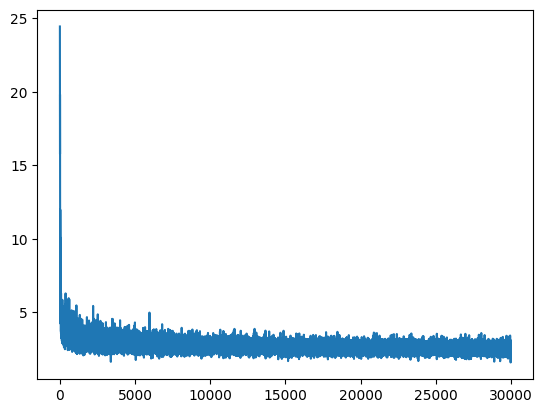

In [43]:
plt.plot(stepi, lossi)

One possibility of optimizing - the batch size is so low (32) that there is too much noise - increase to have more correct gradient and optimize more properly.

In [44]:
# Evaluate
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4506, grad_fn=<NllLossBackward0>)

In [45]:
# Evaluate
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4542, grad_fn=<NllLossBackward0>)

Expect a lower loss than before since we have a much bigger model and we were underfitting.

Even though we made the tanh layer much bigger it could be that the bottleneck of the network are the embeddings that are 2-dimensional - cramming way too many characters in 2 dimensions and the NN is not able to use that space effectively.

Visualise embedding vectors after training - can do it with 2 dimensions.

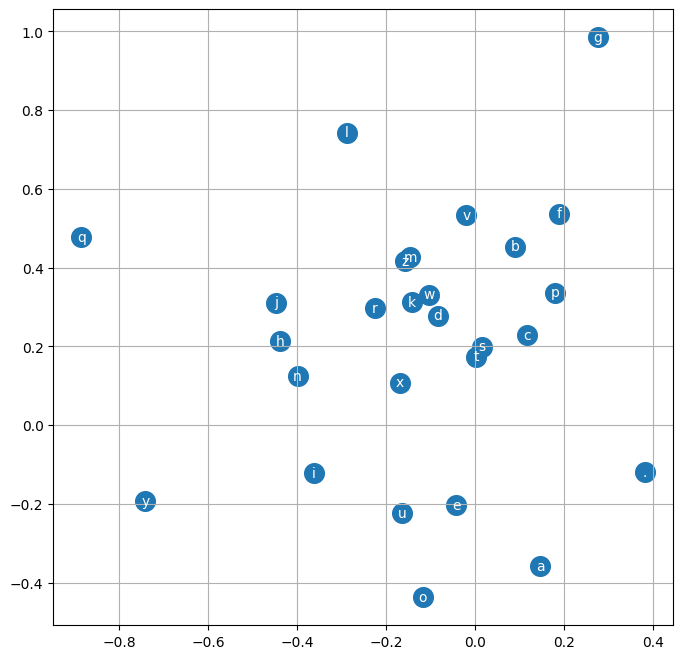

In [46]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')